<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Segment customers of a website - P5</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Analysis notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [51]:
## General
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Own specific functions 
from  functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

In [2]:
df_customers = pd.read_csv(r"datasets\olist_customers_dataset.csv")
df_products = pd.read_csv(r"datasets\olist_products_dataset.csv")


df_geolocation = pd.read_csv(r"datasets\olist_geolocation_dataset.csv")
df_order_items = pd.read_csv(r"datasets\olist_order_items_dataset.csv")
df_order_payments = pd.read_csv(r"datasets\olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv(r"datasets\olist_order_reviews_dataset.csv")
df_orders = pd.read_csv(r"datasets\olist_orders_dataset.csv")

df_sellers = pd.read_csv(r"datasets\olist_sellers_dataset.csv")
df_product_category_name_translations = pd.read_csv(r"datasets\product_category_name_translation.csv")

<div class="alert alert-block alert-info">
    <p>The following description of each dataset, is organized in order of importance</p>
    <ul>
       <li><b>Customer</b> dataset <b>"olist_customers_dataset.csv"</b>.<br>
           Basic customer information
        </li>
       <li><b>Order</b> dataset <b>"olist_orders_dataset.csv"</b>.<br>
           The order header with the order status
        </li>
       <li><b>Product</b> dataset <b>"olist_products_dataset.csv"</b>.<br>
           Product declarative information (category, lenght, weight, etc.)
        </li>
       <li><b>Order Items</b> dataset <b>"olist_orders_dataset.csv"</b>.<br>
           List of products ands sellers related to the order
        </li>
       <li><b>Order Payments</b> dataset <b>"olist_order_payments_dataset.csv"</b>.<br>
           All payments and its methods, related to the order
        </li>
       <li><b>Seller</b> dataset <b>"olist_sellers_dataset.csv"</b>.<br>
           Basic seller information
        </li>
       <li><b>Product Category Translation</b> dataset <b>"product_category_name_translation.csv"</b>.<br>
           Product name translation
        </li>
       <li><b>Order Reviews</b> dataset <b>"olist_order_reviews_dataset.csv"</b>.<br>
           Order reviews
        </li>
       <li><b>Geolocation</b> dataset <b>"olist_order_reviews_dataset.csv"</b>.<br>
           Geolocation data
        </li>
    </ul>
</div>

![Entity relationship diagram](images/entity_relationship.png)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Initial analysis</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Based on dataset metadata located in <a href="https://www.kaggle.com/olistbr/brazilian-ecommerce", target="blank", style="font-weight: bold;">Kaggle</a>, we are going to see in details, each dataset</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Customers</h3>
</div>

In [69]:
df_analysis(df_customers, "df_customers", columns=["customer_id", "customer_unique_id"], type_analysis="complete")


Analysis of df_customers dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['customer_id', 'customer_unique_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 3.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,99441,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer_zip_code_prefix,int64,99441,14994,0,0.00000,35137.47458,1003.00000,11347.00000,24416.00000,58900.00000,99990.00000,29797.93900
3,customer_city,object,99441,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer_state,object,99441,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


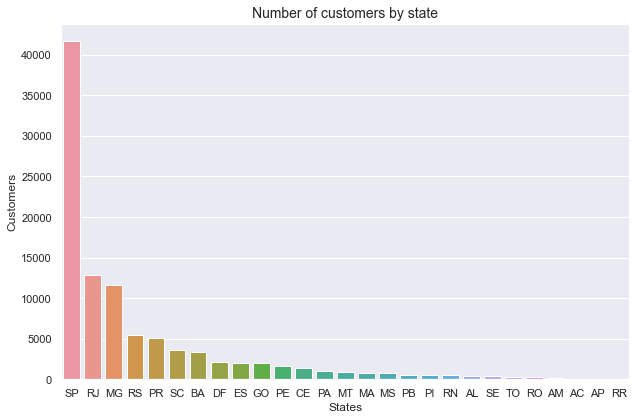

In [66]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_customers["customer_state"].value_counts().index, y=df_customers["customer_state"].value_counts(), data=df_customers)
plt.xlabel("States", size=12)
plt.ylabel("Customers", size=12)
plt.title("Number of customers by state", size=14)
plt.tight_layout()
plt.savefig("images/number-of-customer-by-state.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with basic information about customer. Below we can see some descriptions about its columns</p>
    <ul>
        <li>customer_unique_id is the pk.</li>
        <li>There is not missing-values</li>
        <li>There are 96096 customers</li>
        <li>There are 14994 zip codes</li>
        <li>There are 4119 cities</li>
        <li>There are 27 states</li>
        <li>SP (Sao Paulo) has twice as many customers as the second state with the most customers </li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Products</h3>
</div>

In [67]:
df_analysis(df_products, "df_products", columns=["product_id"], type_analysis="complete")


Analysis of df_products dataset
--------------------------------------------------------------------
- Dataset shape:                  32951 rows and 9 columns
- Total of NaN values:            2448
- Percentage of NaN:              0.83 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['product_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 2.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,product_id,object,32951,32951,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,product_weight_g,float64,32949,2204,2,0.01000,2276.47249,0.00000,300.00000,700.00000,1900.00000,40425.00000,4282.03873
6,product_length_cm,float64,32949,99,2,0.01000,30.81508,7.00000,18.00000,25.00000,38.00000,105.00000,16.91446
7,product_height_cm,float64,32949,102,2,0.01000,16.93766,2.00000,8.00000,13.00000,21.00000,105.00000,13.63755
8,product_width_cm,float64,32949,95,2,0.01000,23.19673,6.00000,15.00000,20.00000,30.00000,118.00000,12.07905
1,product_category_name,object,32341,73,610,1.85000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name_lenght,float64,32341,66,610,1.85000,48.47695,5.00000,42.00000,51.00000,57.00000,76.00000,10.24574
3,product_description_lenght,float64,32341,2960,610,1.85000,771.49528,4.00000,339.00000,595.00000,972.00000,3992.00000,635.11522
4,product_photos_qty,float64,32341,19,610,1.85000,2.18899,1.00000,1.00000,1.00000,3.00000,20.00000,1.73677


In [70]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


<div class="alert alert-block alert-info">
    <p>We are going to merge the products datasets with products translations dataset</p>
</div>

In [104]:
df_product_category_name_translations.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [105]:
df_products = df_products.merge(right=df_product_category_name_translations[["product_category_name", "product_category_name_english"]], on="product_category_name", how="left")

In [106]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [109]:
print("Number of \"products categories\" to complete with \"products categories translated\" is:",
        df_products[(df_products["product_category_name"].isna()) & (df_products["product_category_name_english"].notnull())].shape[0]
)

NUmber of "products categories" to complete with "products categories translated" is: 0


In [112]:
print("Number of \"products categories translated\" to complete with \"products categories\" is:",
        df_products[(df_products["product_category_name_english"].isna()) & (df_products["product_category_name"].notnull())].shape[0]
)

Number of "products categories translated" to complete with "products categories" is: 13


<div class="alert alert-block alert-info">
    <p>Fill products categories translated with the original name of category</p>
</div>

In [115]:
df_products["product_category_name_english"].fillna(df_products["product_category_name"], inplace=True)

In [116]:
print("Number of \"products categories translated\" to complete with \"products categories\" is:",
        df_products[(df_products["product_category_name_english"].isna()) & (df_products["product_category_name"].notnull())].shape[0]
)

Number of "products categories translated" to complete with "products categories" is: 0


In [117]:
del df_products["product_category_name"]

<div class="alert alert-block alert-info">
    <p>Identifying the categories with more products</p>
</div>

In [119]:
df_number_products_category = pd.DataFrame(df_products.groupby(["product_category_name_english"])["product_id"].count().sort_values(ascending=False).head(20)).reset_index()

In [120]:
df_number_products_category.head()

,product_category_name_english,product_id
0,bed_bath_table,3029
1,sports_leisure,2867
2,furniture_decor,2657
3,health_beauty,2444
4,housewares,2335


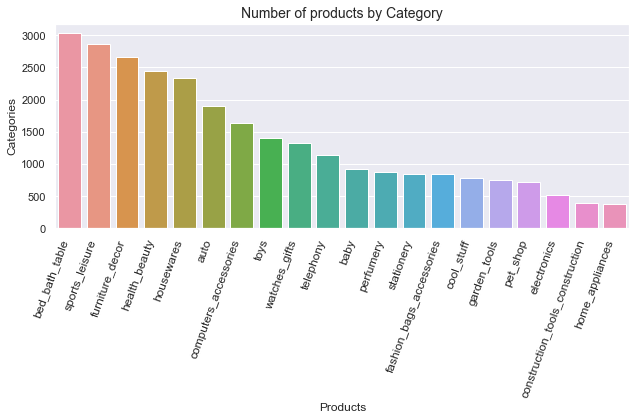

In [121]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_number_products_category["product_category_name_english"], y=df_number_products_category["product_id"], data=df_number_products_category)

plot.set_xticklabels(labels=df_number_products_category["product_category_name_english"], rotation=70, size=12, horizontalalignment="right")
plt.xlabel("Products", size=12)
plt.ylabel("Categories", size=12)
plt.title("Number of products by Category", size=14)
plt.tight_layout()
plt.savefig("images/number-of-products-by-category.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with information about products. Below we can see some descriptions about its columns</p>
    <ul>
        <li>product_id is the pk.</li>
        <li>There are some missing-values</li>
    </ul>
</div>

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with information about category name translation to english</p>
    <ul>
        <li>Each column can be used as pk.</li>
        <li>There are some missing-values</li>
    </ul>
</div>

In [11]:
df_analysis(df_sellers, "df_sellers", columns=["seller_id"], type_analysis="complete")


Analysis of df_sellers dataset
--------------------------------------------------------------------
- Dataset shape:                  3095 rows and 4 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['seller_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 96.8+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,seller_id,object,3095,3095,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,seller_zip_code_prefix,int64,3095,2246,0,0.00000,32291.05945,1001.00000,7093.50000,14940.00000,64552.50000,99730.00000,32713.45383
2,seller_city,object,3095,611,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,seller_state,object,3095,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with basic information about sellers. This table shares almost the same attributes as customer's dataset</p>
    <ul>
        <li>seller_id can be used as pk.</li>
        <li>There is not missing-values</li>
    </ul>
</div>

In [14]:
df_analysis(df_orders, "df_orders", columns=["order_id"], type_analysis="complete")


Analysis of df_orders dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 8 columns
- Total of NaN values:            4908
- Percentage of NaN:              0.62 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.


,name,type,records,# NaN,% NaN
0,order_id,object,99441,0,0.00000
1,customer_id,object,99441,0,0.00000
2,order_status,object,99441,0,0.00000
3,order_purchase_timestamp,object,99441,0,0.00000
7,order_estimated_delivery_date,object,99441,0,0.00000
4,order_approved_at,object,99281,160,0.16000
5,order_delivered_carrier_date,object,97658,1783,1.79000
6,order_delivered_customer_date,object,96476,2965,2.98000


In [16]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [17]:
df_orders["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order status information. We can say that it is the order header</p>
    <ul>
        <li>order_id can be used as pk.</li>
        <li>There are missing-values in fields related to delivery</li>
    </ul>
</div>

In [18]:
df_analysis(df_order_items, "df_order_items", columns=["order_id", "order_item_id"],  type_analysis="complete")


Analysis of df_order_items dataset
--------------------------------------------------------------------
- Dataset shape:                  112650 rows and 7 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id', 'order_item_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 6.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,112650,98666,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_item_id,int64,112650,21,0,0.00000,1.19783,1.00000,1.00000,1.00000,1.00000,21.00000,0.70512
2,product_id,object,112650,32951,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,seller_id,object,112650,3095,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,shipping_limit_date,object,112650,93318,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,price,float64,112650,5968,0,0.00000,120.65374,0.85000,39.90000,74.99000,134.90000,6735.00000,183.63393
6,freight_value,float64,112650,6999,0,0.00000,19.99032,0.00000,13.08000,16.26000,21.15000,409.68000,15.80641


In [19]:
df_order_items.sort_values("order_id").head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [20]:
df_order_items[df_order_items["order_id"] == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order products </p>
    <ul>
        <li>order_id together with order_item_id, can be used as pk.<br> It is necessary to consider that a customer can buy the same product several times in the same order</li>
        <li>There are not missing-values</li>
    </ul>
</div>

In [21]:
df_analysis(df_order_payments, "df_order_payments", columns=["order_id"], type_analysis="complete")


Analysis of df_order_payments dataset
--------------------------------------------------------------------
- Dataset shape:                  103886 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 4.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,103886,99440,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,payment_sequential,int64,103886,29,0,0.00000,1.09268,1.00000,1.00000,1.00000,1.00000,29.00000,0.70658
2,payment_type,object,103886,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,payment_installments,int64,103886,24,0,0.00000,2.85335,0.00000,1.00000,1.00000,4.00000,24.00000,2.68705
4,payment_value,float64,103886,29077,0,0.00000,154.10038,0.00000,56.79000,100.00000,171.83750,13664.08000,217.49406


In [22]:
df_order_payments[df_order_payments.duplicated(subset=["order_id"], keep=False)].head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
35,b2bb080b6bc860118a246fd9b6fad6da,1,credit_card,1,173.84
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
84,723e462ce1ee50e024887c0b403130f3,1,credit_card,1,13.80
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
139,82ffe097d8ddbf319a523b9bbe7725d5,2,voucher,1,30.00
161,c61e3efc183db6b89f5556efb5aa8797,1,credit_card,1,45.50
164,487c1451b8fd7347d0e80e5aca887e91,2,voucher,1,30.00
166,65c863d90026e9dd4888e28d2135c983,2,voucher,1,50.00


In [23]:
df_order_payments[df_order_payments["order_id"] == "ea9184ad433a404df1d72fa0a8764232"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
40168,ea9184ad433a404df1d72fa0a8764232,1,credit_card,1,17.78
78613,ea9184ad433a404df1d72fa0a8764232,3,voucher,1,22.49
94151,ea9184ad433a404df1d72fa0a8764232,2,voucher,1,22.49
99425,ea9184ad433a404df1d72fa0a8764232,5,voucher,1,22.47


In [24]:
df_order_payments["payment_type"].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with details of order payments. The customer can puy the same order through several  payment methods</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are not missing-values</li>
    </ul>
</div>

In [25]:
df_analysis(df_order_reviews, "df_order_reviews", columns=["review_id"], type_analysis="complete")


Analysis of df_order_reviews dataset
--------------------------------------------------------------------
- Dataset shape:                  100000 rows and 7 columns
- Total of NaN values:            146532
- Percentage of NaN:              20.93 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['review_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 5.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,review_id,object,100000,99173,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_id,object,100000,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,review_score,int64,100000,5,0,0.00000,4.07089,1.00000,4.00000,5.00000,5.00000,5.00000,1.35966
5,review_creation_date,object,100000,637,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,review_answer_timestamp,object,100000,99010,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_comment_message,object,41753,36921,58247,58.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,review_comment_title,object,11715,4600,88285,88.28000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_order_reviews[df_order_reviews.duplicated(subset=["order_id"], keep=False) & df_order_reviews["review_comment_message"].notnull()].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1063,9c0ff4d25d28bd004057ce16540abc3d,45390ff93f092f0de1524d486a172c33,1,NaN,A mercadoria não foi entregue ainda..,2018-03-21 00:00:00,2018-03-26 22:01:59
1119,c8d187a7c6b2a9ae76018912fc5711c3,0e457aee274ec7e2e18d25ab6d212921,5,NaN,O produto é muito lindo e está com preço excel...,2018-01-01 00:00:00,2018-01-03 14:46:29
1612,b06f6882b1c0bc82ddf057b58b86fe50,2daee070f2042c8b7a8e9fdde778a31a,5,Muito bom,"Ótimo, excelente produto recomendo a todos",2018-07-12 00:00:00,2018-07-13 10:49:12
1983,a59277055ee75dc9a536fd48e9c2946e,f0fbc60d51bb40c156688d9ce008237f,2,NaN,Foi entregue uma quantidade do produto. Sendo ...,2018-01-31 00:00:00,2018-02-01 13:52:17
2000,03a6a25db577d0689440933055111897,2acfdc5131ff2cf4433e668454c9784c,5,NaN,Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...,2017-12-15 00:00:00,2017-12-16 01:32:18


In [27]:
df_order_reviews.loc[df_order_reviews["order_id"] == "0e457aee274ec7e2e18d25ab6d212921"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1119,c8d187a7c6b2a9ae76018912fc5711c3,0e457aee274ec7e2e18d25ab6d212921,5,NaN,O produto é muito lindo e está com preço excel...,2018-01-01 00:00:00,2018-01-03 14:46:29
90279,58b4629d5cf0507f7f8b9ae84c146544,0e457aee274ec7e2e18d25ab6d212921,5,NaN,"Excelente qualidade dos adesivos, entrega supe...",2018-01-04 00:00:00,2018-01-04 17:40:42


In [28]:
df_order_reviews[df_order_reviews.duplicated(subset=["review_id"], keep=False) & df_order_reviews["review_comment_message"].notnull()].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
348,f4d74b17cd63ee35efa82cd2567de911,f269e83a82f64baa3de97c2ebf3358f6,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10
837,6ec93e77f444e0b1703740a69122e35d,d8cbc79d1dd84f3c87cb2ca7663c930e,5,NaN,Vendedor compromisso do vou o cliente,2017-10-07 00:00:00,2017-10-07 19:47:11
992,1f5aa5d7c3ee7895e4d223797b5a5f2d,c79bdf061e22288609201ec60deb42fb,5,NaN,Tudo ocorreu de forma eficiente,2017-05-10 00:00:00,2017-05-12 00:58:11
1016,3242cc306a9218d0377831e175d62fbf,711246846695fa895c1776f0ddc30b20,5,NaN,Ótimo,2017-07-21 00:00:00,2017-07-22 01:06:37
1489,b703764760e6e5d534a8940a12fca101,2b49d60af10ea7e2443376987ec8a184,1,NaN,Só veio uma capa comprei 3 aí paguei. Mais de ...,2017-04-11 00:00:00,2017-04-14 11:02:46


In [29]:
df_order_reviews.loc[df_order_reviews["review_id"] == "f4d74b17cd63ee35efa82cd2567de911"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
348,f4d74b17cd63ee35efa82cd2567de911,f269e83a82f64baa3de97c2ebf3358f6,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10
91014,f4d74b17cd63ee35efa82cd2567de911,a60c9bf6dcdd39e9f1c10ae5ad77c24d,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order reviews. It seems there are reviews repeated for differentes orders</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are missing-values</li>
    </ul>
</div>

In [30]:
df_analysis(df_geolocation, "df_geolocation", columns=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], type_analysis="complete")


Analysis of df_geolocation dataset
--------------------------------------------------------------------
- Dataset shape:                  1000163 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  261831
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 38.2+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,geolocation_zip_code_prefix,int64,1000163,19015,0,0.00000,36574.16647,1001.00000,11075.00000,26530.00000,63504.00000,99990.00000,30549.33571
1,geolocation_lat,float64,1000163,717360,0,0.00000,-21.17615,-36.60537,-23.60355,-22.91938,-19.97962,45.06593,5.71587
2,geolocation_lng,float64,1000163,717613,0,0.00000,-46.39054,-101.46677,-48.57317,-46.63788,-43.76771,121.10539,4.26975
3,geolocation_city,object,1000163,8011,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,geolocation_state,object,1000163,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_geolocation.sort_values("geolocation_zip_code_prefix").head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with geolocation data. There is not a clear relation among this dataset and Customers and Sellers dataset.<br>It is possible to consider only the city, state and zip code</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.3. Summary based on Initial Analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">X. Initial analysis</h2>
</div>

In [3]:
df_analysis(df_customers, "df_customers", columns=["customer_id"], type_analysis="complete")


Analysis of df_customers dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['customer_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 3.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,99441,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer_zip_code_prefix,int64,99441,14994,0,0.00000,35137.47458,1003.00000,11347.00000,24416.00000,58900.00000,99990.00000,29797.93900
3,customer_city,object,99441,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer_state,object,99441,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">X. Joining datasets</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to start with <b>df_orders</b> and <b>df_customers</b></p>
</div>

In [ ]:
data = df_order.merge(right=df_customer[["customer_id", "customer_unique_id", "customer_zip_code_prefix", "customer_city", "customer_state"]], on="customer_id", how="left")

In [ ]:
data.head()

In [ ]:
df_analysis(df_customer, "df_customer", columns=["customer_id"], type_analysis="complete")

In [ ]:
df_analysis(df_order, "df_order", columns=["order_id"], type_analysis="complete")

In [ ]:
df_orders.head()

In [ ]:
df_customer.head()

In [ ]:
df_customer.shape

In [ ]:
df_customer[~df_customer["customer_unique_id"].isin(df_orders["customer_id"])].shape

In [ ]:
df_data_copy[~df_data_copy["2-alpha code"].isin(df_countries_iso["Code"])].head(10)

In [ ]:
df_customer = pd.read_csv(r"datasets\olist_customers_dataset.csv")
df_geolocation = pd.read_csv(r"datasets\olist_geolocation_dataset.csv")
df_order_items = pd.read_csv(r"datasets\olist_order_items_dataset.csv")
df_order_payments = pd.read_csv(r"datasets\olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv(r"datasets\olist_order_reviews_dataset.csv")
df_orders = pd.read_csv(r"datasets\olist_orders_dataset.csv")
df_products = pd.read_csv(r"datasets\olist_products_dataset.csv")
df_sellers = pd.read_csv(r"datasets\olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv(r"datasets\product_category_name_translation.csv")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

https://www.definitions-marketing.com/definition/segmentation-rfm/
https://lms.simplilearn.com/courses/4414/Introduction-to-Supervised-&-Unsupervised-Machine-Learning/syllabus

https://classroom.udacity.com/courses/st101
https://classroom.udacity.com/courses/ud827
https://www.freecodecamp.org/news/free-machine-learning-course-10-hourse/

https://towardsdatascience.com/10-highly-probable-data-scientist-interview-questions-fd83f7414760